<a href="https://colab.research.google.com/github/Gabriel-git24/Cacao_disease_classification/blob/main/project_ds2(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install keras-tuner --quiet
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras_tuner as kt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 5.5 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
# need to sort images into folders based on their labels
# # DO NOT UNCOMMENT THIS,
# THIS IS TO DIVIDE THE IMAGES INTO FOLDERS BASED ON THEIR LABELS
# AND THEN USES SPLITFOLDER TO CREATE TRAIN TEST VALIDATION

# sana = "/content/drive/MyDrive/Data_Science_Project_fall2024/Data Science Project/Enfermedades Cacao/Sana"
# fito = "/content/drive/MyDrive/Data_Science_Project_fall2024/Data Science Project/Enfermedades Cacao/Fito"
# monilia = "/content/drive/MyDrive/Data_Science_Project_fall2024/Data Science Project/Enfermedades Cacao/Monilia"

# def filter_images(directory):
#   image_extension = [".jpg", ".jpeg", ".png"]
#   destination_dir = directory + "_images" # defining image destination path

#   os.makedirs(destination_dir, exist_ok=True) # creating the destination

#   for filename in os.listdir(directory):
#     file_path = os.path.join(directory, filename)
#     if os.path.isfile(file_path) and filename.lower().endswith(tuple(image_extension)):
#       shutil.copy2(file_path, destination_dir)

# filter_images(sana)
# filter_images(fito)
# filter_images(monilia)'''

# '''!pip install split-folders --quiet

# import splitfolders

# input_folder = "/content/drive/MyDrive/Data_Science_Project_fall2024/Data Science Project/Enfermedades Cacao/binary_classification"
# output_folder = "/content/drive/MyDrive/Data_Science_Project_fall2024/Data Science Project/Enfermedades Cacao/binary_classification/Cacao_Splits"

# splitfolders.ratio(
#     input_folder,
#     output=output_folder,
#     seed=42,
#     ratio = (0.7, 0.15, 0.15),
#     group_prefix=None,
#     move=False
# )

In [3]:
image_size = (224, 224)
batch_size = 32

split_dir = "/content/drive/MyDrive/Data_Science_Project_fall2024/Data Science Project/Enfermedades Cacao/binary_classification/Cacao_Splits"
checkpoint_path = "/content/drive/MyDrive/2/best_model.keras"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.15,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode="nearest"
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=f"{split_dir}/train",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary"
)

validation_generator = val_test_datagen.flow_from_directory(
    directory=f"{split_dir}/val",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary"
)

test_generator = val_test_datagen.flow_from_directory(
    directory=f"{split_dir}/test",
    target_size=image_size,
    batch_size=batch_size,
    class_mode="binary"
)

Found 218 images belonging to 2 classes.
Found 46 images belonging to 2 classes.
Found 48 images belonging to 2 classes.


In [4]:
#HYPERPARAMETER TUNING USING KERAS TUNER

def build_model(hp):
  base_model = MobileNetV2(
      weights = "imagenet",
      include_top = False,
      input_shape = image_size + (3,) # the 3 is for the color channel, in this case the three primary colors
  )
  base_model.trainable = False

  x = base_model.output
  x = GlobalAveragePooling2D()(x)

  #tuning the number of units in the dense layer
  hp_units = hp.Int("units", min_value=32, max_value=256, step=32)
  x = Dense(units=hp_units, activation="relu")(x)

  #tuning the dropout rate
  hp_dropout = hp.Float("dropout", min_value=0.2, max_value=0.5, step=0.1)
  x = Dropout(hp_dropout)(x)

  predictions = Dense(1, activation="sigmoid")(x)

  model = Model(
      inputs = base_model.input,
      outputs = predictions
  )

  #tuning the learning rate
  hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])

  # compiling the model
  model.compile(
      optimizer = Adam(learning_rate=hp_learning_rate),
      loss = "binary_crossentropy",
      metrics = ["accuracy"]
  )

  return model

# tuner = kt.Hyperband(
#     build_model,
#     objective="val_accuracy",
#     max_epochs=10,
#     factor=3,
#     directory="my_dir",
#     project_name="my_project"
# )

early_stopping = EarlyStopping(
    monitor = "val_loss",
    patience = 5,
    restore_best_weights = True
)

tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=2,
    directory="/content/drive/MyDrive/2",
    project_name="mobile_net_tuning"
)

tuner.search(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Reloading Tuner from /content/drive/MyDrive/2/mobile_net_tuning/tuner0.json


In [5]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal hyperparameters are:
- Units in Dense layer: {best_hps.get('units')}
- Dropout rate: {best_hps.get('dropout'):.2f}
- Learning rate for Adam: {best_hps.get('learning_rate'):.5f}
""")

# Getting the best model
best_model = tuner.get_best_models(num_models=1)[0]


The optimal hyperparameters are:
- Units in Dense layer: 160
- Dropout rate: 0.20
- Learning rate for Adam: 0.00100

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [6]:
#creating a checkpointing to beat timeout on colab

model_checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_weights_only = False,
    monitor = "val_loss",
    save_best_only = True,
    verbose = 1
)

#final_model on training set
history = best_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint_callback]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8325 - loss: 0.4280
Epoch 1: val_loss improved from inf to 0.48367, saving model to /content/drive/MyDrive/2/best_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 129s 17s/step - accuracy: 0.8276 - loss: 0.4365 - val_accuracy: 0.7826 - val_loss: 0.4837
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8286 - loss: 0.3779
Epoch 2: val_loss improved from 0.48367 to 0.47881, saving model to /content/drive/MyDrive/2/best_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - accuracy: 0.8289 - loss: 0.3775 - val_accuracy: 0.8261 - val_loss: 0.4788
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7885 - loss: 0.4504
Epoch 3: val_loss did not improve from 0.47881
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - accuracy: 0.7886 - loss: 0.4470 - val_accuracy: 0.7391 - val_loss: 0.5905
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8204 - loss: 0.3266
Epoch 4: val_loss improved from 0.47881 to 0.46446, saving model to /con

In [7]:
import tensorflow as tf

best_model = tf.keras.models.load_model(checkpoint_path)
test_loss, test_accuracy = best_model.evaluate(test_generator)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 10s/step - accuracy: 0.7014 - loss: 0.5918
Test Loss: 0.5526995658874512
Test Accuracy: 0.7083333134651184


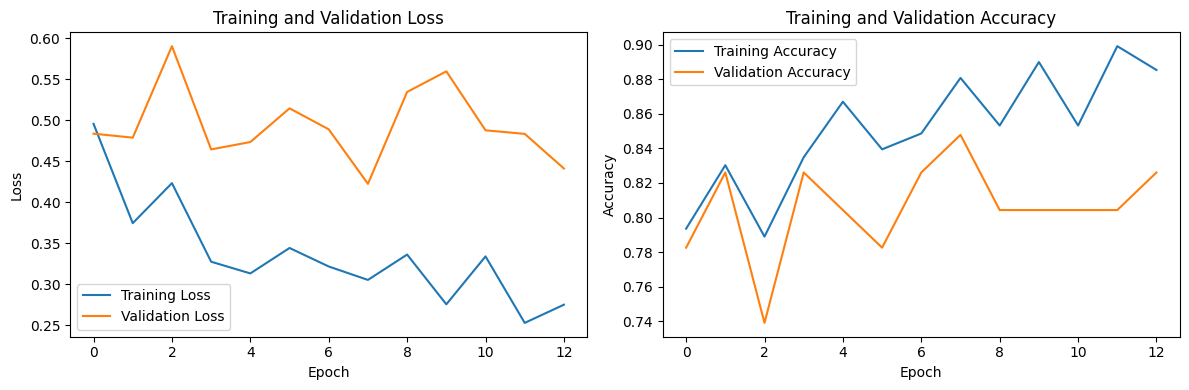

In [8]:
# Plotting training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()